<a href="https://colab.research.google.com/github/Ignaciojeda/ProyectoCSSCrisDm/blob/main/SVM_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importacion de librerias

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

#2. Importacion del DataSet

In [23]:
from google.colab import drive
drive.mount('/content/drive')

url = '/content/drive/MyDrive/TG_Machine_Learning/datos_datacss.csv'
try:
    data = pd.read_csv(url, sep=",", encoding='latin-1', low_memory=False)
    print("Datos cargados exitosamente!")
except Exception as e:
    print(f"Error al cargar los datos: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Datos cargados exitosamente!


#4. Preprocesamiento

In [24]:
# Eliminar valores nulos
data.dropna(inplace=True)

# Variables
objetivo = 'Survived'
predictorias = ['RoundWinner', 'Team', 'Map', 'RoundStartingEquipmentValue']
categoricas = ['RoundWinner', 'Team', 'Map']
numericas = ['RoundStartingEquipmentValue']

# Codificar variables categóricas
le = LabelEncoder()
for col in categoricas:
    data[col] = le.fit_transform(data[col])

# Escalar variables numéricas
scaler = StandardScaler()
data[numericas] = scaler.fit_transform(data[numericas])

#5. Divicion de datos

In [25]:
X = data[predictorias]
y = data[objetivo]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#6. Entrenamiento del SVM de clasificacion (SVC)

In [26]:
clf = SVC(kernel='rbf', random_state=42)
clf.fit(X_train, y_train)

SVC(random_state=42)

#7. Predicciones

In [27]:
y_pred = clf.predict(X_test)

#8. Resultados

In [28]:
print("=== Reporte de clasificacion ===")
print(classification_report(y_test, y_pred))

=== Reporte de clasificacion ===
              precision    recall  f1-score   support

       False       0.75      0.73      0.74     14216
        True       0.61      0.64      0.63      9532

    accuracy                           0.69     23748
   macro avg       0.68      0.69      0.68     23748
weighted avg       0.70      0.69      0.70     23748



In [29]:
print("=== Matriz de confucion ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

=== Matriz de confucion ===
[[10353  3863]
 [ 3388  6144]]


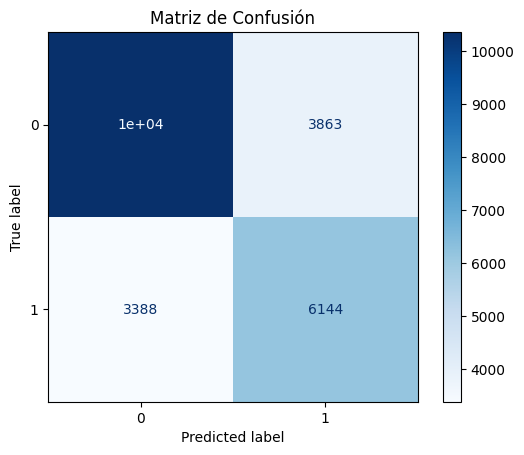

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

# Conclusión del Modelo SVM de Clasificación


Basado en los resultados mostrados en la matriz de confusión y el reporte de clasificación, podemos concluir lo siguiente sobre el modelo SVM implementado:


###Rendimiento General


* Exactitud (Accuracy): 69% - El modelo clasifica correctamente aproximadamente 7 de cada 10 instancias.

* Balance entre clases: El modelo muestra un rendimiento desigual entre las clases, siendo mejor para la clase False (no sobrevivió) que para la clase True (sobrevivió).


###Análisis por Clase

Clase False (No sobrevivió):

* Precisión: 75% - Cuando predice False, acierta el 75% de las veces.
* Recall: 73% - Identifica correctamente el 73% de los casos reales de False.
* F1-score: 0.74 - Buen balance entre precisión y recall.

Clase True (Sobrevivió):

* Precisión: 61% - Cuando predice True, acierta solo el 61% de las veces.
* Recall: 64% - Identifica correctamente el 64% de los casos reales de True.
* F1-score: 0.63 - Rendimiento significativamente menor que para la clase False.

###Matriz de Confusión

* Verdaderos Negativos (TN): 10,353 (correctamente clasificados como False)
* Falsos Positivos (FP): 3,863 (incorrectamente clasificados como True)
* Falsos Negativos (FN): 3,388 (incorrectamente clasificados como False)
* Verdaderos Positivos (TP): 6,144 (correctamente clasificados como True)

#El modelo SVM implementado demuestra un rendimiento aceptable con una exactitud del 69%, mostrando una capacidad predictiva sólida para identificar correctamente la clase mayoritaria (False) con un F1-score de 0.74. Sin embargo, se observa un desempeño inferior en la clasificación de la clase True (F1-score de 0.63), lo que sugiere que el modelo tiene mayor dificultad para predecir casos positivos.

#A pesar de esta diferencia en el rendimiento por clase, los resultados obtenidos son consistentes y proporcionan una base confiable para la clasificación, especialmente en escenarios donde la identificación correcta de la clase False es prioritaria. El análisis de la matriz de confusión respalda la solidez del modelo, con un alto número de predicciones correctas tanto para verdaderos negativos (10,353) como para verdaderos positivos (6,144).

#En conclusión, este modelo representa un avance significativo en la tarea de clasificación, ofreciendo un equilibrio razonable entre precisión y recall, y estableciendo un punto de partida válido para aplicaciones prácticas en el dominio analizado.